In [1]:
%pylab inline
import emcee
from random import *
from observational_data import *
from constants import *
from functions import *
import numpy as np
import time 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def initial_positions(nwalkers):
    mult= 5.
    p = []
    K0 = k0*mult
    K1 = k1*mult
    K2 = k2*mult
    K3 = k3*mult
    for i in range(nwalkers):
        L_0R   = L_0in  *10**(gauss(0.0,K0))
        M_0R   = M_0in  *10**(gauss(0.0,K1))
        betaR  = betain + gauss(0.0,K2)
        gammaR = gammain+ gauss(0.0,K3)    
    ### Some constraints over parameters
        while (L_0R <10**(16.75)) or (L_0R >10**(19.0)):
            L_0R   = L_0in  *10**(gauss(0.0,K0))
        while (M_0R < 10**10.50) or (M_0R > 10**12.00):
            M_0R   = M_0in  *10**(gauss(0.0,K1))
        while (betaR<0) or (betaR>1.6):
            betaR  = betain + gauss(0.0,K2)
        while (gammaR<0) or (gammaR>0.9):
            gammaR = gammain+ gauss(0.0,K3)            
        p.append(array([L_0R, M_0R, betaR, gammaR]))        
    return p          

def lnprob( X, DataSets, BoxLength ):   #X = [M, L_0, M_0, beta, gamma]
    L_0   = X[0]
    M_0   = X[1]
    beta  = X[2]
    gamma = X[3]
    
    ### Restriction over parameters
    if gamma<0:
        return -numpy.inf
    if beta<0:
        return -numpy.inf
    
    L   = np.zeros(M.size)
    ### Create Luminosity Catalog from Halo Mass Catalog and parameters
    L[:]    = Luminosity( M[:], L_0, M_0, beta, gamma)
    ### Create Magnitude Catalog
    Magnitude_UV_galaxy_list = 51.82 - 2.5 * log10(L[:])
    ### Dust Extinction
    if (Dust_Ext == 1):
        Mag = Magnitude_UV_galaxy_list
        Mag[Mag< Mag0] = ( Mag[Mag< Mag0]-4.61455)/1.2587
        Magnitude_UV_galaxy_list = Mag  
    ### Create histograms & Normalize the histograms
    HISTO = []
    for DS in DataSets:
        aux = 1.0*np.histogram(Magnitude_UV_galaxy_list, bins= array(DS[1]) )[0]
        for i in range(len(aux)):
            aux[i] = aux[i]/( (DS[1][i+1] - DS[1][i] ) * BoxLength**3)
        HISTO.append(aux)
    ### Calcule Chi Square using number of Degrees of Freedom
    NOB = 0
    chi_sqr = 0.0
    for i in range(len(HISTO)):
        if (HISTO[i][0]==0):
            HISTO[i][0]+= HISTO[i][1]/1000.0
    for j in range(HISTO[i].size):
            if( HISTO[i][j] != 0.0 ):
                chi_sqr = chi_sqr + 0.5*( log10(HISTO[i][j]/DataSets[i][0][1][j]) / DataSets[i][2][j])**2
                NOB = NOB + 1
            else:
                NOB += DeltaChi
    chi_sqr /= (NOB-4)
    return chi_sqr

In [3]:
### main
DATA = 1 ## Select Box1
STR = '../data/MD_3840_Planck1/BDM/Small_Cells/'+str(DATA)+'.dat'
M = np.loadtxt(STR,usecols=(3,), skiprows=0)
########## Halo mass must be divided by the Hubble Parameter ###
M = M/hpl                                                      #
################################################################
BoxLength = 250 # Mpc h-3

ndim     = 4
nwalkers = 400
nstepsburn=1000
nstepsrun = 10000
#Initial set of positions for the walkers
p0 = initial_positions(nwalkers) #(initial guess)

# Initialize the sampler with the chosen specs.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[Obs_Data, BoxLength],threads=8) #to use 8 processors
#sampler = emcee.EnsembleSampler(n_walkers, n_dimensions, log_likelihood, args=(log_r, log_m),threads=8)

# Run 100 steps as a burn-in.

t0 = time.time()

pos, prob, state = sampler.run_mcmc(p0, nstepsburn)

tf = time.time(); 
print "Burning steps: ", nstepsburn, "\nNumber of Walkers: ", nwalkers,
print "\nBurning time: ", tf - t0, " seconds"
print("Mean acceptance fraction: {0:.3f}".format(mean(sampler.acceptance_fraction)))



sampler.reset()

t0 = time.time()

pos, prob, state = sampler.run_mcmc(p0, nstepsburn)

tf = time.time(); 
print "Running steps: ", nstepsrun, "\nNumber of Walkers: ", nwalkers,
print "\nRunning time: ", tf - t0, " seconds"
print("Mean acceptance fraction: {0:.3f}".format(mean(sampler.acceptance_fraction)))
    


Burning steps:  1000 
Number of Walkers:  400 
Burning time:  1581.2825501  seconds
Mean acceptance fraction: 0.094
Running steps:  10000 
Number of Walkers:  400 
Running time:  1601.12538195  seconds
Mean acceptance fraction: 0.094


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:41: RuntimeWarning: invalid value encountered in log10
functions.py:23: RuntimeWarning: invalid value encountered in power
  return L_0*M*( (M/M_0)**(-beta) + (M/M_0)**gamma)**(-1)
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:41: RuntimeWarning: invalid value encountered in log10
functions.py:23: RuntimeWarning: invalid value encountered in power
  return L_0*M*( (M/M_0)**(-beta) + (M/M_0)**gamma)**(-1)
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:41: RuntimeWarning: invalid value encountered in log10
functions.py:23: RuntimeWarning: invalid value encountered in power
  return L_0*M*( (M/M_0)**(-beta) + (M/M_0)**gamma)**(-1)
functions.py:23: RuntimeWarning: invalid value encountered in power
  return L_0*M*( (M/M_0)**(-beta) + (M/M_0)**gamma)**(-1)
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:41: RuntimeWarning: invalid value encountered in log10
functions.py

(array([ 28221,  85087, 185362,  92190,   8086,    158,    165,     21,
           186,    524]),
 array([  4.17157530e-04,   4.09017935e-01,   8.17618712e-01,
          1.22621949e+00,   1.63482027e+00,   2.04342104e+00,
          2.45202182e+00,   2.86062260e+00,   3.26922337e+00,
          3.67782415e+00,   4.08642493e+00]),
 <a list of 10 Patch objects>)

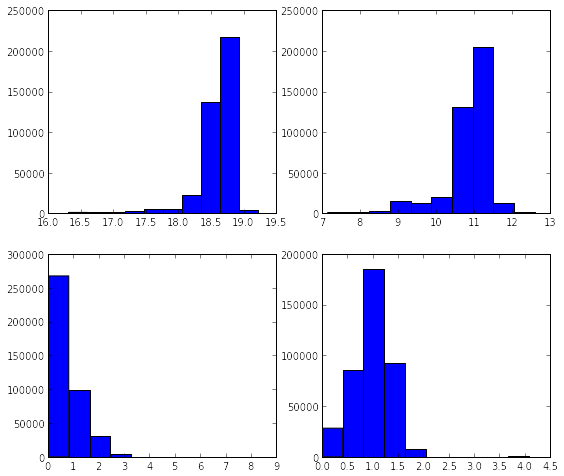

In [4]:
fig = figure(figsize=[9,8])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.hist(log10(sampler.flatchain[:,0]), 10)
ax2.hist(log10(sampler.flatchain[:,1]), 10)
ax3.hist(sampler.flatchain[:,2], 10)
ax4.hist(sampler.flatchain[:,3], 10)


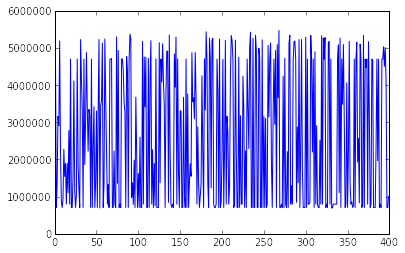

In [5]:
plot(prob)

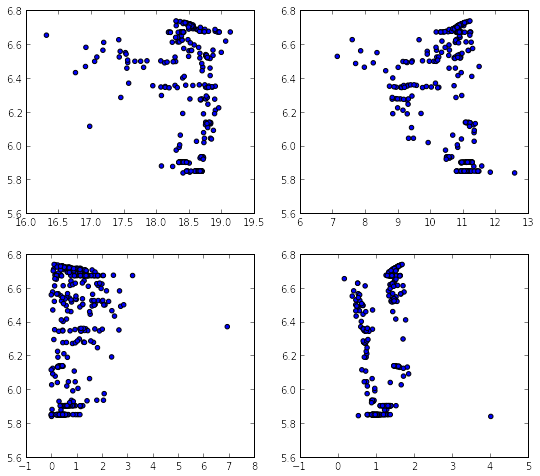

In [6]:
fig = figure(figsize=[9,8])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(log10(pos[:,0]),log10(prob))
ax2.scatter(log10(pos[:,1]),log10(prob))
ax3.scatter(pos[:,2],log10(prob))
ax4.scatter(pos[:,3],log10(prob))

